In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib .image as mpimg
import cv2
%matplotlib inline
from distutils.dir_util import copy_tree
import shutil

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!git clone https://github.com/udacity/CarND-LaneLines-P1.git

Cloning into 'CarND-LaneLines-P1'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 265 (delta 2), reused 7 (delta 1), pack-reused 254 (from 1)
Receiving objects: 100% (265/265), 43.45 MiB | 36.26 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [ ]:
# Reducing Dataset
copy_tree("/content/CarND-LaneLines-P1/test_images","/content/test_images")
copy_tree("/content/CarND-LaneLines-P1/test_videos","/content/test_videos")
shutil.rmtree('/content/CarND-LaneLines-P1',ignore_errors=False, onerror=None)

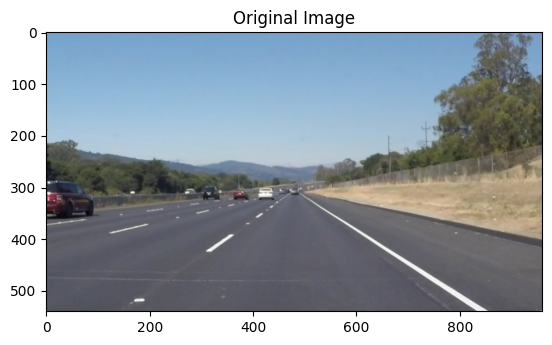

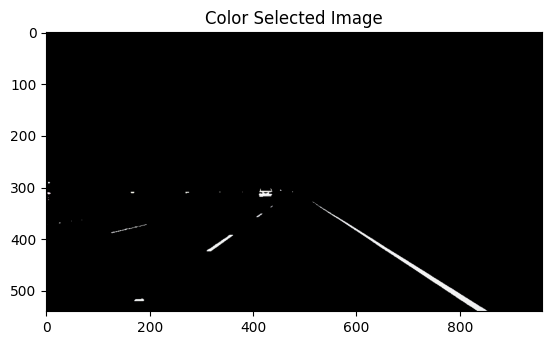

In [ ]:
# Color Selection

from contextlib import redirect_stderr
# RGB value of white is (255,255,255)
image = mpimg.imread('/content/test_images/solidWhiteRight.jpg')

ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)

# Color Selection criteria (ADJUSTABLE)
red_threshold = 200
green_threshold = 200
blue_threshold = 200

# Check pixels below threshold
rgb_threshold = [red_threshold,green_threshold,blue_threshold]
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

# Displaying Image
plt.imshow(image)
plt.title("Original Image")
plt.show()
plt.imshow(color_select)
plt.title("Color Selected Image")
plt.show()

In [ ]:
def polyfit(left_bottom,right_bottom,apex):
  fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
  fit_right = np.polyfit((right_bottom[0],apex[0]), (right_bottom[1],apex[1]), 1)
  fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)
  return fit_left,fit_right,fit_bottom

def mask_pixels(image, rgb_threshold):
  color_thresholds = (image[:,:,0] < rgb_threshold[0]) |\
                     (image[:,:,1] < rgb_threshold[1]) |\
                     (image[:,:,2] < rgb_threshold[2])
  return color_thresholds

def reg_inside_lines():
  X_, Y_ = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
  region_thresholds = ((Y_ > (X_ * fit_left[0] + fit_left[1])) & \
                       (Y_ > (X_ * fit_right[0] + fit_right[1])) & \
                       (Y_ < (X_ * fit_bottom[0] + fit_bottom[1])))
  return region_thresholds

def mask_color_reg_lines(color_thresholds,region_thresholds):
  color_select[color_thresholds | ~region_thresholds] = [0,0,0]
  line_image[~color_thresholds & region_thresholds] = [9, 255,0]
  return color_select,line_image

def display_img(image,color_select,line_image):
  #Displaying region marking
  plt.imshow(image)
  x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
  y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
  plt.plot(x, y, 'r--', lw=4)
  plt.title("Region of Interest")
  plt.show()
  #Displaying color selection in triangular region
  plt.imshow(color_select)
  plt.title("Color selection")
  plt.show()
  #Display line image(green)
  plt.imshow(line_image)
  plt.title("Region Masked Image")
  plt.show()


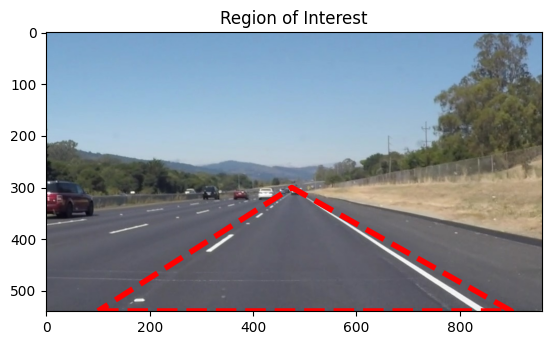

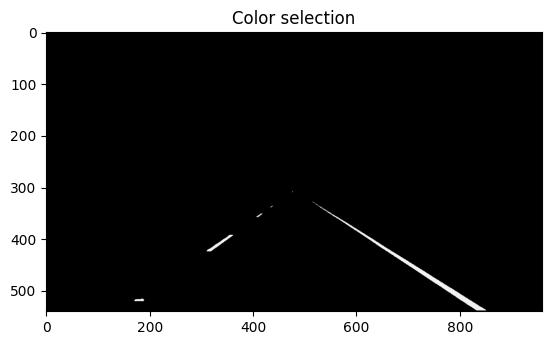

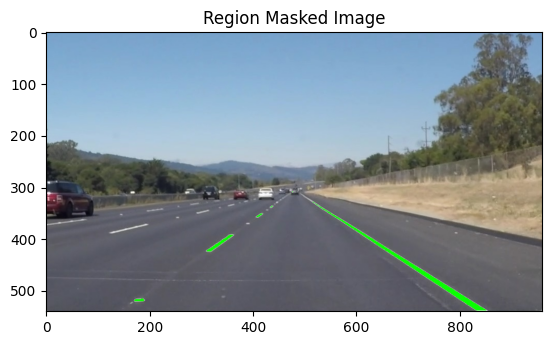

In [ ]:
# Region marking

line_image = np.copy(image)
# Define vertices of triangular mask (ADJUSTABLE)
left_bottom = [100, 539]
right_bottom = [900, 539]
apex = [475, 300]

# Performing Linear fit
fit_left,fit_right,fit_bottom = polyfit(left_bottom,right_bottom,apex)

# Masking pixels below threshold
color_thresholds = mask_pixels(image, rgb_threshold)

# Find region inside lines
region_thresholds = reg_inside_lines()

# Mask color and region selection
color_select,line_image = mask_color_reg_lines(color_thresholds,region_thresholds)

# Displaying Images
display_img(image,color_select,line_image)

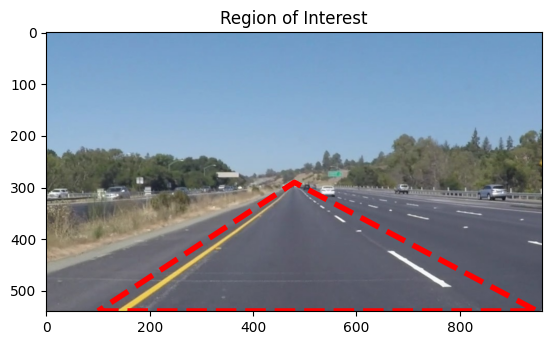

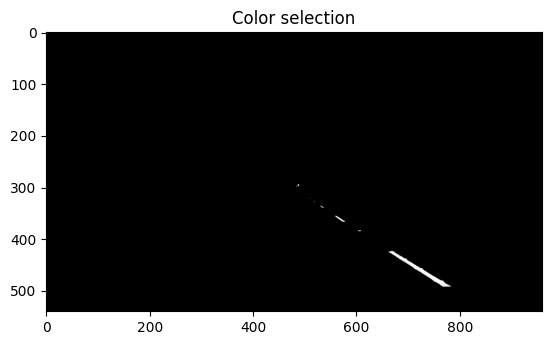

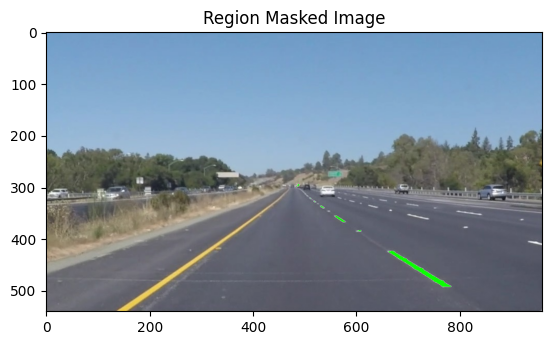

In [ ]:
# Testing

# Reading in an image
image1= mpimg.imread('/content/test_images/solidYellowLeft.jpg')
# xsize & ysize same as before
color_select = np.copy(image1)
line_image = np.copy(image1)
# red, green, blue, rgb thresholds same as before (ADJUSTABLE)
left_bottom = [100, 539]
right_bottom = [950, 539]
apex = [480, 290]

# Performing Linear fit
fit_left,fit_right,fit_bottom = polyfit(left_bottom,right_bottom,apex)

# Masking pixels below threshold
color_thresholds = mask_pixels(image1, rgb_threshold)

# Find region inside lines
region_thresholds = reg_inside_lines()

# Mask color and region selection
color_select,line_image = mask_color_reg_lines(color_thresholds,region_thresholds)

# Displaying Images
display_img(image1,color_select,line_image)

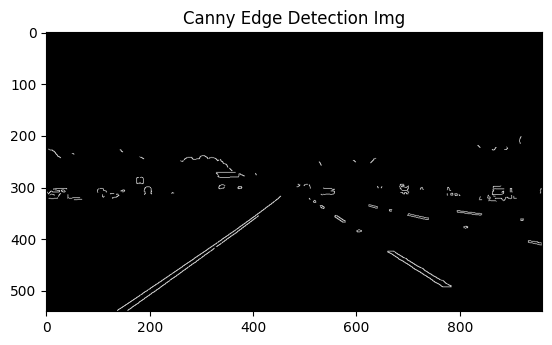

In [ ]:
## Yellow line got missed in Color Detection
#Use Canny Edge Detection to solve this issue

#using image1 convert color to grey
gray = cv2.cvtColor(image1,cv2.COLOR_RGB2GRAY)
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size,kernel_size),0)
# Define parameters for Canny (ADJUSTABLE)
low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
# Displaying Image
plt.imshow(edges,cmap='Greys_r')
plt.title("Canny Edge Detection Img")
plt.show()

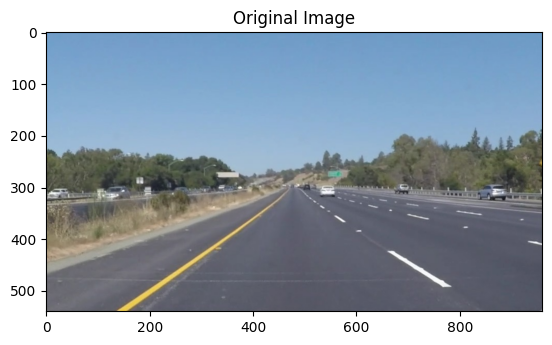

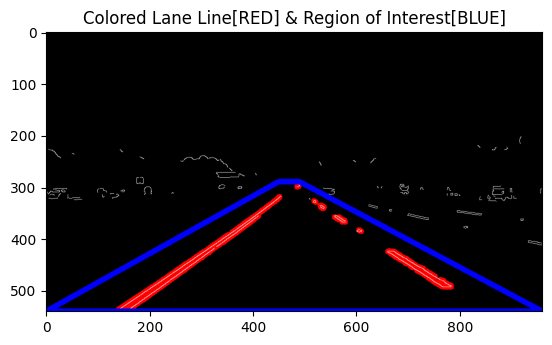

In [ ]:
#Creating masked edges
mask = np.zeros_like(edges)
ignore_mask_color = 255
imshape = image1.shape
vertices = np.array([[(0,imshape[0]),(450, 290), (490,290), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges,mask)
# Hugh Transform parameters
rho=1;theta=np.pi/180;threshold=2;min_line_length=4;max_line_gap=5
line_image = np.copy(image1)*0
lines = cv2.HoughLinesP(masked_edges,rho,theta,threshold,np.array([]),min_line_length,max_line_gap)
#Loop over o/p lines & draw lines on blank image
for line in lines:
  for x1,y1,x2,y2 in line:
    cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
color_edges=np.dstack((edges,edges,edges))
# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges,0.8,line_image,1,0)
lines_edges = cv2.polylines(lines_edges,vertices,True,(0,0,255),10)
plt.imshow(image1)
plt.title("Original Image")
plt.show()
plt.imshow(lines_edges)
plt.title("Colored Lane Line[RED] & Region of Interest[BLUE]")
plt.show()

In [ ]:
'''
Lane Detection Pipeline
  Gray Scale
  Gaussian Smoothing
  Canny Edge Detection
  Region of Interest
  Hough Transform
  Draw Lines[RED] & Region of Interest[BLUE]
  Weighted Image
'''

'\nLane Detection Pipeline\n  Gray Scale\n  Gaussian Smoothing\n  Canny Edge Detection\n  Region of Interest\n  Hough Transform\n  Draw Lines[RED] & Region of Interest[BLUE]\n'

In [ ]:
def grayscale(img):
  return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
  return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
  return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
  mask = np.zeros_like(img)
  if len(img.shape) > 2:
    channel_count = img.shape[2]
    ignore_mask_color = (255,) * channel_count
  else:
    ignore_mask_color = 255
  cv2.fillPoly(mask, vertices, ignore_mask_color)
  masked_image = cv2.bitwise_and(img, mask)
  return masked_image

def draw_lines(img, lines, color=[255,0,0], thickness=10):
  for line in lines:
    for x1,y1,x2,y2 in line:
      cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def slope_lines(image, lines):
  img = image.copy()
  poly_vertices = []
  order = [0,1,3,2]
  left_lines = []
  right_lines = []
  for line in lines:
    for x1,y1,x2,y2 in line:
      if x1 == x2:
        pass
      else:
        m = (y2-y1)/(x2-x1)
        c = y1 - m * x1
        if m < 0:
          left_lines.append([m,c])
        else:
          right_lines.append([m,c])
  left_line = np.mean(left_lines, axis=0)
  right_line = np.mean(right_lines, axis=0)

  #Print (left_line & right line)
  for slope, intercept in [left_line, right_line]:
    rows, colmns = image.shape[:2]
    y1= int(rows)
    y2= int(rows * 0.6)
    # y = mx+c so x = (y-c)/m
    x1= int((y1 - intercept)/slope)
    x2= int((y2 - intercept)/slope)
    poly_vertices.append((x1,y1))
    poly_vertices.append((x2,y2))
  poly_vertices = [poly_vertices[i] for i in order]
  cv2.fillPoly(img, np.array([poly_vertices], dtype=np.int32), color = (0,0,255))
  return cv2.addWeighted(image, 0.7, img, 0.4, 0.)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
  lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
  line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
  #draw_lines(line_img, lines)
  line_img = slope_lines(line_img,lines)
  return line_img

def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
  lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
  return lines_edges

def get_vertices(image):
  rows, colmns = image.shape[:2]
  bottom_left  = [colmns*0.15, rows]
  top_left     = [colmns*0.45, rows*0.6]
  bottom_right = [colmns*0.95, rows]
  top_right    = [colmns*0.55, rows*0.6]

  ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
  return ver

In [ ]:
# Lane Finding Pipeline
def lane_finding_pipeline(image):
  #Grayscale
  gray_img = grayscale(image)
  #Gaussian Smoothing
  smoothed_img = gaussian_blur(img = gray_img, kernel_size=5)
  #Canny Edge Detection
  canny_img = canny(img = smoothed_img, low_threshold=180, high_threshold=240)
  #Masked Image within Polynomal
  masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
  #Hough Transform Lines
  houghed_lines = hough_lines(img = masked_img, rho=1, theta=np.pi/180, threshold=20, min_line_len=20, max_line_gap=180)
  #Weighted Image
  output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
  return output


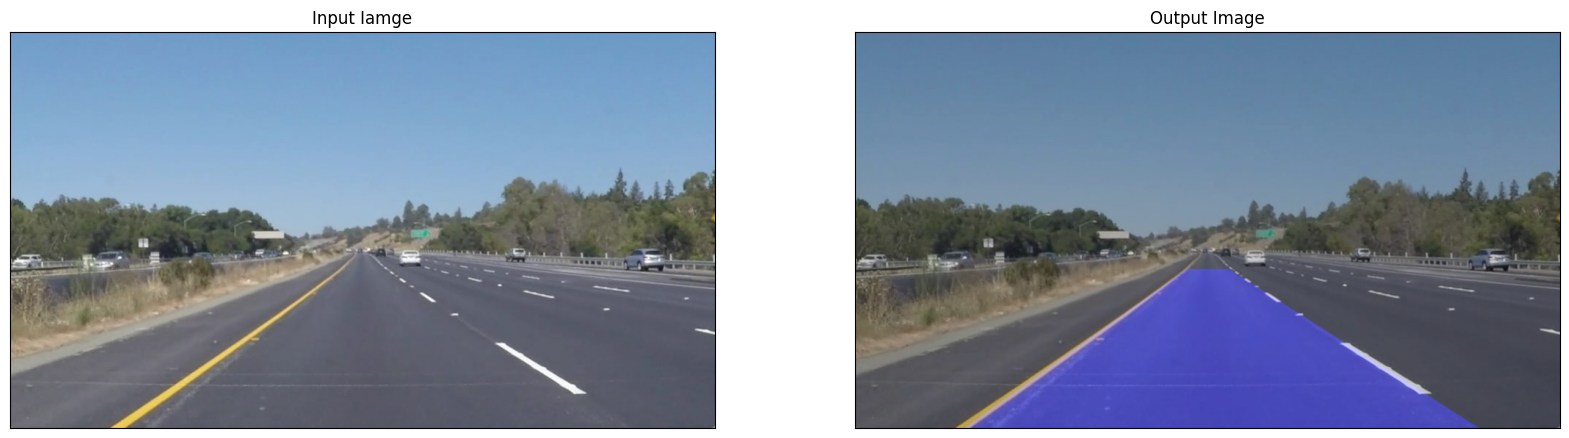

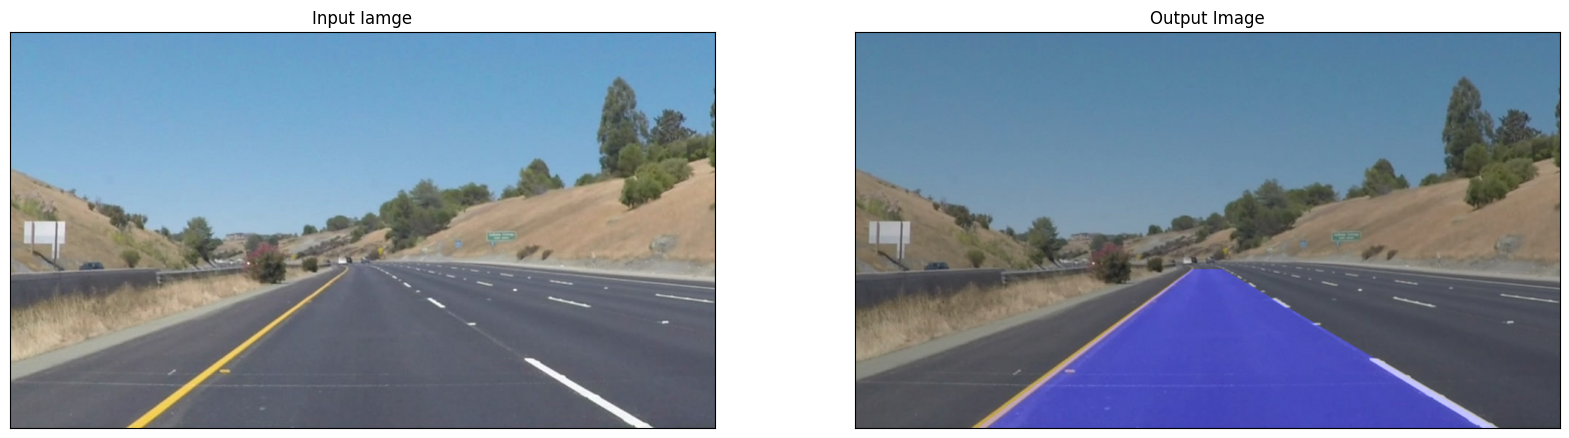

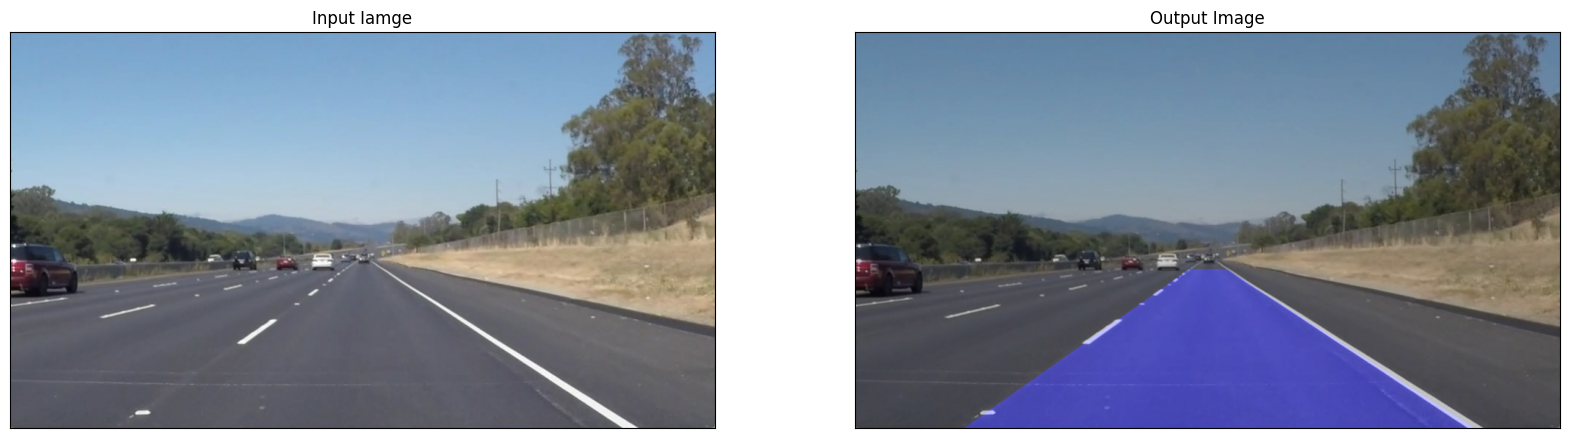

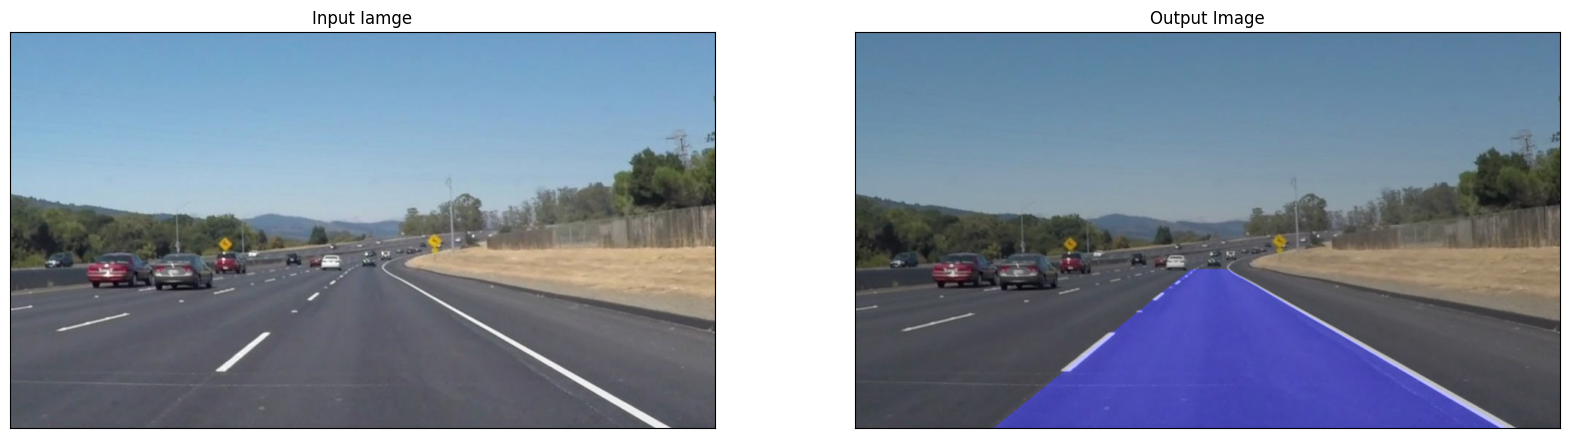

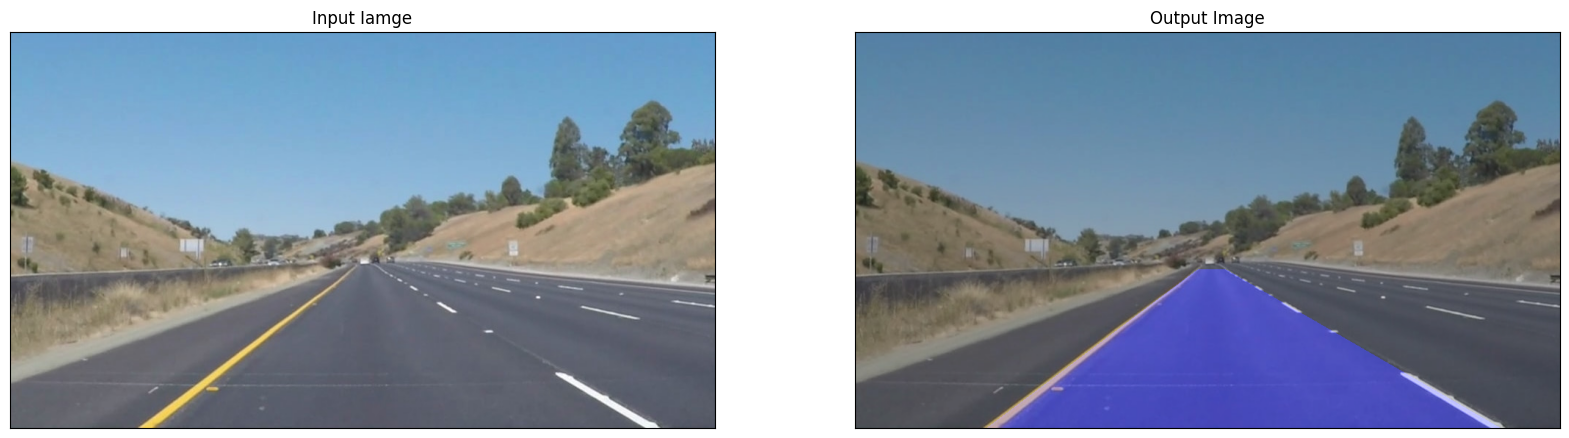

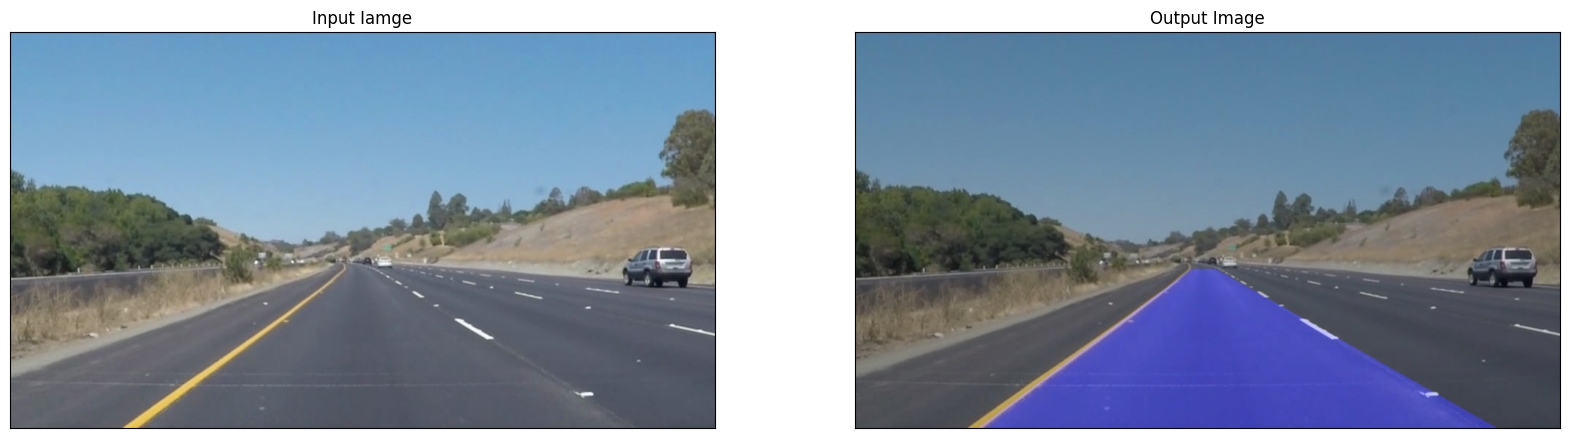

In [ ]:
#### Testing our Algo
for image_path in list(os.listdir("/content/test_images")):
  fig = plt.figure(figsize=(20,10))
  image = mpimg.imread("/content/test_images/" + image_path)
  ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
  plt.imshow(image)
  ax.set_title('Input Iamge')
  ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
  plt.imshow(lane_finding_pipeline(image))
  ax.set_title('Output Image')
  plt.show()

In [ ]:
#Edit and watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# Test with live video clip 1

white_output = '/content/white.mp4'
clip1 = VideoFileClip("/content/test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(lane_finding_pipeline)
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video /content/white.mp4.
Moviepy - Writing video /content/white.mp4



Moviepy - Done !
Moviepy - video ready /content/white.mp4
CPU times: user 2.75 s, sys: 446 ms, total: 3.2 s
Wall time: 14.6 s


In [ ]:
# Output Video
HTML("""
<video width="960" height="500" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
# Test with video clip 2
yellow_output = '/content/yellow.mp4'
clip2 = VideoFileClip('/content/test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(lane_finding_pipeline)
%time yellow_clip.write_videofile(yellow_output,audio=False)

Moviepy - Building video /content/yellow.mp4.
Moviepy - Writing video /content/yellow.mp4



Moviepy - Done !
Moviepy - video ready /content/yellow.mp4
CPU times: user 8.48 s, sys: 1.36 s, total: 9.84 s
Wall time: 43.6 s


In [ ]:
# Output Video
HTML("""
<video width="960" height="500" controls>
  <source src="{0}">
</video>
""".format(yellow_output))